<a href="https://colab.research.google.com/github/denocris/Deep-Learning-Lectures_CV/blob/master/meetup_denoising_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Denoising Variational Autoencoder with TF 2.0 </center></h1>


  
  <center>  <img src=  https://drive.google.com/uc?id=1NizfTetPzdNakOwyTuA2y-MQYnZEqNYU " width="700">  </center> 
  <center>  <img src=https://drive.google.com/uc?id=1A6QMi7EGwnyeee8DsD7UJ0V_ssWyCNNE " width="700">  </center> 


This notebook con be found [here](https://github.com/denocris/MHPC-DeepLearning-Lectures) on my  GitHub. I suggest you to open it in Google Colab! 

### Some Refs

* [What is a Variational Autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

* [Variational Autoencoder by Jonathan Hui](https://jhui.github.io/2017/03/06/Variational-autoencoders/)

* [Variational autoencoders by Jeremy Jordan](https://www.jeremyjordan.me/variational-autoencoders/)

* Original Papers: [Kingma et al.](https://arxiv.org/abs/1312.6114) and [Rezende et al.](https://arxiv.org/abs/1401.4082)


### What are we going to learn?

* Working on Google Colaboratory

* First time ever using the new TensorFlow 2.0

* Important [Information Theory](https://www.amazon.com/Elements-Information-Theory-Telecommunications-Processing/dp/0471241954) Concepts 

* How to build a Denoising VAE in TensorFlow

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf

In [0]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
import math as m
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import time


from IPython import display


<img src="https://drive.google.com/file/d/1Y52T3Z4dwRU4Rq5L5bEVYh0d3kU0aVB8/view?usp=sharing" alt="">


## <h1><center>  Information Theory Background 


### Self-Information

The idea behind self-information is the following

* if an event always occurs, we associate it with a smaller amount of information. It will not suprise us!
* On the other side, a rare event is associated with a huge amount of information. It will suprise us!

I am not surprise to see the sunrise every morning (likely event). Instead,  I would be really suprised if tomorrow the Sun will not rise (unlikely event). This amount of surprise or self-information of the event $x$ is quantified by

$$I(x) = - \log p(x),$$

where $p(x)$ is the probability of the event $x$. If $p(x)=1$, then self-info is zero. A rare event instead has a huge surpise factor.

### Shannon Entropy 

In terms of self-info, Shannon Entropy is the average self-information (expected value) over all possible values of X.
The entropy for a probability $p(x)$ distribution is

$$ S = - \sum_i p(x_i) \log p(x_i),$$

where we assume we know the probability $p$ for each outcome $i$. If we use $log_2$  for our calculation we can interpret entropy as *the minimum number of bits it would take us to encode our information*.

For continous variables, we can use the integral form

$$ S = - \int  p(x) \log p(x) \, dx,$$

where now $p(x)$ is taking the role of a probability density function (PDF). Take in mind that a broad probability density has higher entropy than a narrowed one (think about Gaussian distribution vs delta Dirac, which has $S=0$).

In both discrete and continous formulation, we are computing the expectation (i.e. average) of the negative log-probability (i.e. self-info) which is the theoretical minimum encoding size of the information from the event $x$. The same formula is usually written as

$$S = \mathbb E _{\, x \sim p} \left[ -\log p(x) \right],$$

where $x \sim p$ means that we calculate the expectation with the probability distribution $p$.

Let's give an example! 

<!---
  REMIND to change open with uc
 https://drive.google.com/open?id=1Y52T3Z4dwRU4Rq5L5bEVYh0d3kU0aVB8
--->

  <center>  <img src=https://drive.google.com/uc?id=1GaAeK8xIZCVDRb-oHQNUzRuoOprFh1eS " width="700">  </center> 

Let's say we have to pass a message about what drink Cristiano would take during an event. In general, Cristiano loves [Midori Sour](https://drizly.com/midori-sour/r-b972d5282bec6fe8) , Daiquiri, Spritz and Wine.

On Monday, Cristiano loves to listen Jazz and the probability distribution of his choice is: 

$$P(\text Midori ) =  P(\text Daiquiri ) = P(\text Spritz ) = P(\text Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} = 2$$

On Wednesday, he usually meets with some friends after work: 

$$P(\text Midori ) = 0.125,\;  P(\text Daiquiri ) =0.125,\;  P(\text Spritz ) = 0.5,\; P(\text  Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{8} \log \frac{1}{8} - \frac{1}{8} \log \frac{1}{8} - \frac{1}{2} \log \frac{1}{2} - \frac{1}{4} \log \frac{1}{4} = 1.75$$


On Thursday, he often goes to an event where cocktail attire dress code is required

$$P(\text Midori ) = 0.95,\;  P(\text Daiquiri ) =0.02,\;  P(\text Spritz ) = 0.018,\; P(\text  Wine ) = 0.012,$$

and the corresponding entropy

$$S = - 0.95 \log 0.95 - 0.02 \log 0.02 - 0.018 \log 0.018 - 0.012 \log 0.012 = 0.364$$

In [0]:
# On Monday, all drinks have equal probability to be chose
entropy_1 = -0.25*m.log(0.25,2)-0.25*m.log(0.25,2)-0.25*m.log(0.25,2)-0.25*m.log(0.25,2)
print('On Monday, high entropy: ', entropy_1)

# On Wednesday, some are more probable than others
entropy_2 = -0.5*m.log(0.5,2)-0.25*m.log(0.25,2)-0.125*m.log(0.125,2)-0.125*m.log(0.125,2)
print('On Wednesday, medium entropy: ', entropy_2)

# On Thursday, one drink is by far the most probable
entropy_3 = -0.95*m.log(0.95,2)-0.02*m.log(0.02,2)-0.018*m.log(0.018,2)-0.012*m.log(0.012,2)
print('On Thursday, low entropy: ', entropy_3)

On Monday, high entropy:  2.0
On Wednesday, medium entropy:  1.75
On Thursday, low entropy:  0.36407300467232967


If entropy is high (encoding size $log_2 p(x)$ is big on average), it means we have many message types with small and almost equal probabilities. Hence, every time a new message arrives, you would expect a different type than previous messages. You may see it as a disorder or uncertainty or unpredictability.

On the contrary, when a message has much smaller probability than other message, it appears as a surprise because on average you would expect other more frequently sent message types. Moreover, a rare message type has more information than more frequent message types because it eliminates a lot of other probabilities and tells us more specific information.

In the drink scenario, by sending “Wine” on thursday which happens 1.2% of the times, we are reducing the uncertainty by 98.8% of the probability distribution (“Midori, Daiquiri, Spritz”) provided we had no information before. If we were sending “Midori” (95%) instead, we would be reducing the uncertainty by 5% only.

If the entropy is high (ex: fair coin), the average encoding size is significant which means each message tends to have more (specific) information. Again, this is why high entropy is associated with disorder, uncertainty, surprise, unpredictability, amount of information. The more random a message is, the more information will be gained from decoding the message.

Low entropy (ex: sunrise) means that most of the times we are receiving the more predictable information which means less disorder, less uncertainty, less surprise, more predictability and less (specific) information. This is the Thursday case.

### Cross Entropy

Suppose to have two distributions, the true one $p(x)$ and the estimated $q(x)$. In the language of neural networks, $p(x)$ would be the grond truth (labels in one hot-encoding) and $q(x)$ the outcome of the net, i.e. the one that your machine learning algorithm is trying to match. Cross entropy is a mathematical tool for comparing two probability distributions $p(x)$ and $q(x)$ and it is expressed by the formula 

$$ H (p,q) = - \int p(x) \log q(x)\,dx.$$

If $\log$ is in base $2$, then cross entropy measures the number of bits you will need encoding symbols from $p$ using the wrong distribution $q$. Subtracting to cross entropy the entropy of $p$, you are counting the cost in terms of bits of using the wrong distribution $q$ (this somehow will be KL-divergence). 

### Kullback-Leibler Divergence

KL-divergence is just a slight modification of our formula for entropy. Rather than just having our probability distribution $h$ we add into the game our approximating distribution $g$. Then we look at the difference of the log values for each

$$D_{KL}(h || g) = - \sum_i h(x_i) (\log h(x) - \log g(x)) = - \sum_i h(x_i) \log \frac{h(x)}{g(x)}$$ 

KL-divergence is the expectation of the log-difference between the probability of data in the original distribution $h$ with the approximating distribution $g$. Again, if we think in terms of $\log_2$ we can interpret this as how many bits of information we expect to lose when we choose an approximation $g$ of our original ditribution $h$. 

In the variational autoencoder loss function, the KL-divergence is used to force the distribution of latent variables $q(z | x)$ to be a normal distribution $n(z)$ so that we can sample latent variables from the normal distribution. As such, the KL-divergence is included in the loss function to improve the similarity between the distribution of latent variables and the normal distribution. More about **KL** can be found [here](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) and about **cross-entropy** [here](https://towardsdatascience.com/demystifying-cross-entropy-e80e3ad54a8).

##  Autoencoder vs Variational Autoencoder

<center>  
<p>      
<img src=https://drive.google.com/uc?id=1QdiSESYkbNnigrbH-GutlGtRuC6QbGpw  width="800" height="250">  
<img src=https://drive.google.com/uc?id=1IiuzC8YeZ_MXJsYg1BgJV-o3VMoQUGvI width="800" height="250">    
 <p>
</center> 

## <h1><center> Coding our Denoising VAE

### Importing Data and Add some Gaussian Noise

In [0]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')


# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.


print("train_images.shape: ", train_images.shape)
print("test_images.shape: ", test_images.shape)

noise_variance = 0.2
train_images_noisy = train_images + np.random.normal(0, noise_variance, (train_images.shape[0], train_images.shape[1],train_images.shape[2],train_images.shape[3])).astype('float32')
test_images_noisy = test_images + np.random.normal(0, noise_variance, (test_images.shape[0], test_images.shape[1],test_images.shape[2], test_images.shape[3])).astype('float32')




train_images.shape:  (60000, 28, 28, 1)
test_images.shape:  (10000, 28, 28, 1)


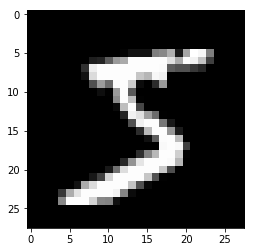

In [0]:
image = train_images[0]
image = np.array(image, dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

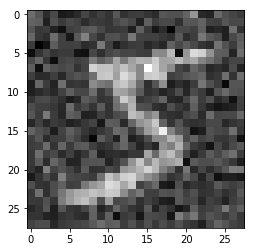

In [0]:
noisy_image = train_images_noisy[0]
noisy_image = np.array(noisy_image, dtype='float')
pixels = noisy_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

### Transforming Data in TF Dataset Object

In [0]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
train_dataset_noisy = tf.data.Dataset.from_tensor_slices(train_images_noisy).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)
test_dataset_noisy = tf.data.Dataset.from_tensor_slices(test_images_noisy).batch(BATCH_SIZE)

### Using Class to define a Model (From TensorFlow Official Page)

   
```python
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()
```


### Defining our Variational Autoencoder Model
<center>  <img src=https://drive.google.com/uc?id=14dNERtYBOiyEq3cPOUFObUe6Ul4cn_r0  " width="800">  </center> 

In [0]:

class VAutoEncoder(tf.keras.Model):
  def __init__(self, latent_dim):
    
    super(VAutoEncoder, self).__init__()
    self.latent_dim = latent_dim
    
    # Encoder
    self.encoder_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=3, kernel_size=10, strides=(2, 2), padding="SAME", activation=tf.nn.relu),
          tf.keras.layers.Conv2D(
              filters=3, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.relu),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    # Decoder
    self.decoder_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(2, 2), 
              padding="SAME",
              activation=tf.nn.relu),
          tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=10, strides=(2, 2),
              padding="SAME",
              activation=tf.nn.relu),
          
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

### Gaussian Distribution and Loss Function

The Gaussian distribution is defined by

$$ N (x\mid \mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}} .$$


Taking its log we obtain

$$ \log N (x\mid \mu ,\sigma ^{2})= - \frac{1}{2} \left( \log2\pi  + \log \sigma ^2  +  \frac {(x-\mu )^{2}}{\sigma ^{2}}\right) = - \frac{1}{2} \left( \log2\pi  + \log\sigma ^2 +  (x-\mu )^{2} \exp (- \log\sigma^2)\right).$$

The loss function of a VAE is

$$l_i(\theta, \phi) = - \mathbb{E}_{\,z\sim q_{\theta}(z | x_i)} \left[ \log p_{\phi}(x_i|z) \right] + \mathbb K \mathbb L ( q_{\theta}(x_i | z) \, || \, n(z) ),$$ 

where the first term is the reconstruction loss, or expected negative log-likelihood of the $i$-th datapoint, while the second is the KL-divergence. The former encourages the decoder to learn to reconstruct the data.The latter is a regularizer that forces the encoder’s distribution to be as much as possible similar to a Gaussian distribution.The final total loss function is $L =\frac{1}{N} \sum_i l_i$.

  
  <center>  <img src=https://drive.google.com/uc?id=1_UmDN6a2I2bktY4nVgT1N2uC-pFxoXo_ " width="800">  </center> 

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x_input, x_target):
    mean, logvar = model.encode(x_input)
    # This is the key ingredient!
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x_target)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x_input, x_target):
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x_input, x_target)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))


### Defining Training Parameters

In [0]:
epochs = 10
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])


model = VAutoEncoder(latent_dim)

In [0]:
#random_vector_for_generation

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  
def original_image(model, images):
  
  fig = plt.figure(figsize=(4,4))

  for i in range(images.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(images[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

  
def clean_images(model, test_input):
  
  mean, logvar = model.encode(test_input)
  z = model.reparameterize(mean, logvar)
  predictions = model.decode(z, apply_sigmoid=True)
  #predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
#generate_and_save_images(model, 0, random_vector_for_generation)


for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x_noisy, train_x in zip(train_dataset_noisy, train_dataset):
    gradients, loss = compute_gradients(model, train_x_noisy, train_x)
    apply_gradients(optimizer, gradients, model.trainable_variables)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x_noisy, test_x in zip(test_dataset_noisy, test_dataset):
      loss(compute_loss(model, test_x_noisy,  test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
#    generate_and_save_images(
#        model, epoch, random_vector_for_generation)
    



Epoch: 10, Test set ELBO: -152.4878692626953, time elapse for current epoch 13.718701362609863


In [0]:
test_dataset_to_be_cleaned = tf.data.Dataset.from_tensor_slices(test_images_noisy).batch(4)


cnt = 0

for images in test_dataset_to_be_cleaned:
  #print(image.shape)
  original_image(model, images)
  clean_images(model, images)
  time.sleep(5)
  display.clear_output(wait=False)
  cnt += 1
  if cnt > 10:
    sys.exit()

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
